In [1]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = ''
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [2]:
import jax.numpy as jnp
from jax import random, vmap, clear_caches, jit
import numpy as np

import optax
from equinox.nn import Conv1d
import matplotlib.pyplot as plt
from functools import partial
from time import perf_counter

from data.dataset import dataset_Krylov, dataset_FD
from linsolve.cg import ConjGrad
from linsolve.precond import llt_prec
from model import MessagePassing, FullyConnectedNet, PrecNet, ConstantConv1d, MessagePassingWithDot

from utils import params_count, asses_cond, iter_per_residual, batch_indices
from data.utils import direc_graph_from_linear_system_sparse
from train import train

# Setup experiment

In [71]:
dataset = 'simple'                # 'krylov', 'simple'
grid = 4
N_samples_train = 30
N_samples_test = 5

rhs_train = rhs_test = [5, 5, 2]           # 'random', 'laplace', [5, 5, 2]
k_train = k_test = 'poisson'           # 'random', 'poisson', [5, 5, 2]
rhs_offset_train = rhs_offset_test = 0
k_offset_train = k_offset_test = 10
lhs_type = 'fd'

cg_repeats = 300
if dataset == 'simple': cg_repeats = 1

In [72]:
layer_ = ConstantConv1d         # 'ConstantConv1d' to make a "zero" NN initialization; 'Conv1d' to make a random initialization
loss_type = 'notay'               # Either 'llt' or 'notay'
with_cond = True               # If True will calculate cond during training. Extremly bad scaling (materialization of matrix)
with_final_cond = False         # If True will calculate cond with final L. Also bad scaling

In [73]:
batch_size = 8
lr = 5e-4
epoch_num = 100

In [74]:
# # Uncomment and setup to make steps in learning rate

# steps_per_batch = N_samples_train * cg_repeats // batch_size
# start, stop, step = 45*steps_per_batch, 101*steps_per_batch, 45*steps_per_batch
# decay_size = 1e-1
# lr = optax.piecewise_constant_schedule(
#     lr,
# #     {k: v for k, v in zip([37], [1e-1])}
#     {k: v for k, v in zip(np.arange(start, stop, step), [decay_size, ] * len(jnp.arange(start, stop, step)))}
# )

# Make dataset

In [75]:
s1 = perf_counter()
if dataset == 'krylov':
    A_train, b_train, u_exact_train, bi_edges_train, res_train, u_app_train = dataset_Krylov(grid, N_samples_train, seed=42, rhs_distr=rhs_train, rhs_offset=rhs_offset_train,
                                                                                             k_distr=k_train, k_offset=k_offset_train, cg_repeats=cg_repeats, lhs_type=lhs_type)
    A_test, b_test, u_exact_test, bi_edges_test, res_test, u_app_test = dataset_Krylov(grid, N_samples_test, seed=43, rhs_distr=rhs_test, rhs_offset=rhs_offset_test,
                                                                                       k_distr=k_test, k_offset=k_offset_test, cg_repeats=cg_repeats, lhs_type=lhs_type)
elif dataset == 'simple':
    A_train, b_train, u_exact_train, bi_edges_train = dataset_FD(grid, N_samples_train, seed=42, rhs_distr=rhs_train, rhs_offset=rhs_offset_train,
                                                                 k_distr=k_train, k_offset=k_offset_train, lhs_type=lhs_type)
    A_test, b_test, u_exact_test, bi_edges_test = dataset_FD(grid, N_samples_test, seed=43, rhs_distr=rhs_test, rhs_offset=rhs_offset_test,
                                                             k_distr=k_test, k_offset=k_offset_test, lhs_type=lhs_type)
print(perf_counter() - s1)

5.814397179987282


In [76]:
receivers.shape

(344,)

(30, 64) (30, 64) (30, 64)
(40,) (40,) (40,)


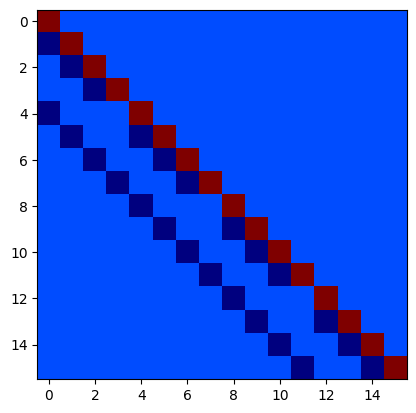

In [126]:
from data.utils import direc_graph_from_linear_system_sparse, graph_tril, graph_to_low_tri_mat_sparse
from jax.experimental import sparse as jsparse 

nodes, edges, receivers, senders, _ = direc_graph_from_linear_system_sparse(A_train, b_train)
print(edges.shape, receivers.shape, senders.shape)
nodes, edges, receivers, senders = nodes[0, ...][None, ...], edges[0, ...], receivers[0, ...], senders[0, ...]
nodes, edges, receivers, senders = graph_tril(nodes, edges, receivers, senders)
print(edges.shape, receivers.shape, senders.shape)

# abc_tril = vmap(graph_to_low_tri_mat_sparse, in_axes=(0, 0, 0, 0), out_axes=(0))(nodes[None, ...], edges[None, ...], receivers[None, ...], senders[None, ...])
abc_tril = graph_to_low_tri_mat_sparse(nodes, edges, receivers, senders)
# abc_tril.data = abc_tril.data * 0 + 1
plt.imshow(abc_tril.todense());

In [127]:
abc_tril.indices[:, 0]

Array([ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  5,  6,  6,  6,  7,  7,
        7,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11, 12, 12, 13, 13, 13,
       14, 14, 14, 15, 15, 15], dtype=int32)

In [128]:
abc_tril.indices[:, 1]

Array([ 0,  0,  1,  1,  2,  2,  3,  0,  4,  1,  4,  5,  2,  5,  6,  3,  6,
        7,  4,  8,  5,  8,  9,  6,  9, 10,  7, 10, 11,  8, 12,  9, 12, 13,
       10, 13, 14, 11, 14, 15], dtype=int32)

In [229]:
i = 5
abc_tril_csr.indptr[i+1] - abc_tril_csr.indptr[i]

Array(3, dtype=int32)

In [420]:
import jax
GRID = grid

# @partial(jit, static_argnums=(2, 4))
def jspsolve_triangular_efficient(A_, b, lower=True):
    '''A must be a lower/upper triangular matrix.
       It should be "valid": not singular (have no zeros on diagonal, no empty rows, etc.)'''
#     Aval, bval = A.data, b
#     Arows, Acols = A.indices[:, 0], A.indices[:, 1]
#     Aindptr = jsparse.BCSR.from_bcoo(A).indptr
    A = jsparse.BCSR.from_bcoo(A_)
#     x = jnp.zeros(bval.shape[0] + 1)
    x = jnp.copy(b)
#     A = A.sum_duplicates()

    if lower:
#         f_pointer = partial(pointer_over_dim, iterate_dim=Arows, retrive_dim=Acols)
#         dim_range = jnp.arange(1, x.shape[0])
        dim_range = jnp.arange(x.shape[0])
#         x = x.at[0].set(bval[0] / Aval[0])
    else:
#         f_pointer = partial(pointer_over_dim, iterate_dim=Acols, retrive_dim=Arows)
#         dim_range = jnp.arange(x.shape[0] - 2, -1, -1)
        dim_range = jnp.arange(x.shape[0] - 1, -1, -1)
#         x = x.at[-1].divide(bval[-1] / Aval[-1])
    
#     for i in dim_range:
#         lhs_ind = f_pointer(i)
# #         rhs_ind = rhs_ind[:-1]
#         nondiag_ind, diag_ind = lhs_ind[:-1], lhs_ind[-1]
        
#         c = jnp.sum(Aval.at[nondiag_ind].get() * x.at[rhs_ind].get())
#         x = x.at[i].set(bval[i]-c)
#         x = x.at[i].divide(Aval[diag_ind])
        
    for i in dim_range:

        # Get indices for i-th row.
        indptr_start = A.indptr[i]
        indptr_stop = A.indptr[i + 1]

        if lower:
            A_diagonal_index_row_i = indptr_stop - 1
            A_off_start, A_off_end = indptr_start, indptr_stop - 1
#             A_off_diagonal_indices_row_i = jax.lax.slice(indptr_start, indptr_stop - 1)
        else:
            A_diagonal_index_row_i = indptr_start
            A_off_start, A_off_end = indptr_start + 1, indptr_stop
#             A_off_diagonal_indices_row_i = jax.lax.slice(indptr_start + 1, indptr_stop)

        # Incorporate off-diagonal entries.
        print(A.indices.ndim, A.indices.shape)
        A_column_indices_in_row_i = jax.lax.dynamic_slice_in_dim(A.indices, A_off_start, A_off_end)
        A_values_in_row_i = jax.lax.dynamic_slice_in_dim(A.data, A_off_start, A_off_end)
#         A_column_indices_in_row_i = A.indices.at[A_off_start:A_off_end].get()
#         A_values_in_row_i = A.data.at[A_off_start:A_off_end].get()
#         A_column_indices_in_row_i = A.indices[A_off_diagonal_indices_row_i]
#         A_values_in_row_i = A.data[A_off_diagonal_indices_row_i]
        x = x.at[i].add(-jnp.dot(x[A_column_indices_in_row_i].T, A_values_in_row_i))

        # Compute i-th entry of x.
        x = x.at[i].divide(A.data[A_diagonal_index_row_i])

    return x
        
# def pointer_over_dim(i, iterate_dim, retrive_dim):
#     '''Returns all indices in the columns/row of the i-th row/column.'''
#     A_pos = jnp.nonzero(jnp.where(iterate_dim == i, 1, 0), size=GRID**2/2, fill_value=GRID**2)[0].astype(jnp.int32)
# #     x_pos = retrive_dim[A_pos]
#     return A_pos#, x_pos

In [421]:
x1 = jax.jit(jspsolve_triangular_efficient, static_argnums=(2))(abc_tril, b_train[0, :], lower=True)
# x1 = jspsolve_triangular_efficient(abc_tril, b_train[0, :], lower=True)
display(x1)
nodes[0, :] - abc_tril @ x1

1 (40,)


TracerIntegerConversionError: The __index__() method was called on traced array with shape int32[].
The error occurred while tracing the function jspsolve_triangular_efficient at /tmp/ipykernel_314911/1117027653.py:5 for jit. This concrete value was not available in Python because it depends on the values of the arguments A_[<flat index 0>] and A_[<flat index 1>].
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerIntegerConversionError

In [ ]:
Adata = abc_tril.data
Aindices = abc_tril.indices
Aindptr = jsparse.BCSR.from_bcoo(abc_tril).indptr

x1 = jspsolve_triangular_efficient(Adata, Aindices, Aindptr, b_train[0, :], lower=True)
display(x1)
nodes[0, :] - abc_tril @ x1

In [679]:
import jax

@partial(jit, static_argnums=(2))
def jspsolve_triangular_efficient(A, b, lower):
    '''A must be a lower/upper triangular matrix.
       It should be "valid": not singular (have no zeros on diagonal, no empty rows, etc.)'''
    Aval, bval = A.data, b
    Arows, Acols = A.indices[:, 0], A.indices[:, 1]
    x = jnp.zeros_like(bval)    
    
    diag_edge_indx = jnp.diff(jnp.hstack([Arows[:, None], Acols[:, None]]))
    diag_edge_indx = jnp.where(diag_edge_indx == 0, 1, 0)
    diag_edge_indx = jnp.nonzero(diag_edge_indx, size=nodes.shape[1], fill_value=jnp.nan)[0].astype(jnp.int32)
    
    if lower:
        dim_range = jnp.arange(1, x.shape[0])
        x = x.at[0].set(bval[0] / Aval[0])
    else:
        dim_range = jnp.arange(x.shape[0] - 2, -1, -1)
        x = x.at[-1].divide(bval[-1] / Aval[-1])
    
#     for i, diag_ind in zip(dim_range, diag_edge_indx[1:]):
#         nondiag_ind = jnp.where(Arows == i, 1, 0)
#         x_i = x.at[jnp.where(nondiag_ind, Acols, Acols.shape[0])].get(mode='fill', fill_value=0)
#         c = jnp.sum(Aval.at[nondiag_ind].get() * x_i)
#         x = x.at[i].set(bval[i]-c)
#         x = x.at[i].divide(Aval[diag_ind])
        
    def f_(carry, k):
        i, diag_ind = k
        Aval_, Arows_, Acols_, bval_, x_ = carry
        nondiag_ind = jnp.where(Arows_ == i, 1, 0)
        x_i = x_.at[jnp.where(nondiag_ind, Acols_, Acols_.shape[0])].get(mode='fill', fill_value=0)
        
        c = jnp.sum(Aval_.at[nondiag_ind].get() * x_i)
        x_ = x_.at[i].set(bval_[i]-c)
        x_ = x_.at[i].divide(Aval_[diag_ind])
        return (Aval_, Arows_, Acols_, bval_, x_), None
    
    carry_ = (Aval, Arows, Acols, bval, x)
    (_, _, _, _, x), _ = jax.lax.scan(f_, carry_, jnp.hstack([dim_range[:, None], diag_edge_indx[1:][:, None]]))
    return x
        

def pointer_over_dim(i, size_, iterate_dim, retrive_dim):
    '''Returns all indices in the columns/row of the i-th row/column.'''
    
#     A_pos = jnp.zeros(N, bool).at[jnp.where(cols==3, rows, N)].set(True, mode='drop')
    A_pos = np.nonzero(np.where(iterate_dim == i, 1, 0))[0].astype(np.int32)
#     A_pos = jnp.nonzero(jnp.where(iterate_dim == i, 1, 0), size=size_, fill_value=0)[0].astype(jnp.int32)
    x_pos = retrive_dim[A_pos]
    return A_pos, x_pos

In [680]:
diag_edge_indx = jnp.diff(jnp.hstack([senders[:, None], receivers[:, None]]))
diag_edge_indx = jnp.where(diag_edge_indx == 0, 1, 0)
diag_edge_indx = jnp.nonzero(diag_edge_indx, size=nodes.shape[1], fill_value=jnp.nan)[0].astype(jnp.int32)
diag_edge_indx

Array([ 0,  2,  4,  6,  8, 11, 14, 17, 19, 22, 25, 28, 30, 33, 36, 39],      dtype=int32)

In [681]:
abc_tril.indices[:, 0]

Array([ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  5,  6,  6,  6,  7,  7,
        7,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11, 12, 12, 13, 13, 13,
       14, 14, 14, 15, 15, 15], dtype=int32)

In [682]:
Adata = abc_tril.data
Aindices = abc_tril.indices
Aindptr = jsparse.BCSR.from_bcoo(abc_tril).indptr

x1 = jspsolve_triangular_efficient(abc_tril, b_train[0, :], lower=True)
display(x1)
nodes[0, :] - abc_tril @ x1

Array([-0.15317   , -0.08858586, -0.10272937, -0.03668332, -0.16018477,
       -0.10423788, -0.10477789, -0.05557638, -0.14603297, -0.05063239,
       -0.04826519, -0.05530344, -0.12375249, -0.01204653,  0.00430035,
        0.01369833], dtype=float32)

Array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.4901161e-08,
       -5.9604645e-08,  7.4505806e-09,  1.4901161e-08, -1.4901161e-08,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],      dtype=float32)

In [220]:
ind = jnp.array([1, 2, 4, 5, 5, 5, 5], dtype=jnp.int32)
val = jnp.arange(10, 20)
display(val)
val[ind]

Array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32)

Array([11, 12, 14, 15, 15, 15, 15], dtype=int32)

In [367]:
import jax
def jspsolve_triangular_efficient(A: jax.experimental.sparse.bcoo.BCOO, Aindptr, b: jax.Array, lower: bool=True) -> jax.Array:
    '''A must be a lower/upper triangular matrix.
       It should be "valid": not singular (have no zeros on diagonal, no empty rows, etc.)'''
    Aval, bval = A.data, b
    Arows, Acols = A.indices[:, 0], A.indices[:, 1]
    x = jnp.zeros_like(bval)

    if lower:
        f_pointer = partial(pointer_over_dim, iterate_dim=Arows, retrive_dim=Acols)
        dim_range = np.arange(1, x.shape[0])
        x = x.at[0].set(bval[0] / Aval[0])
    else:
        f_pointer = partial(pointer_over_dim, iterate_dim=Acols, retrive_dim=Arows)
        dim_range = np.arange(x.shape[0] - 2, -1, -1)
        x = x.at[-1].divide(bval[-1] / Aval[-1])
    
#     for i in dim_range:
#         sl = Aindptr[i+1] - Aindptr[i]
#         lhs_ind, rhs_ind = f_pointer(i, size=sl)
# #         rhs_ind = lhs_ind[:sl]
#         rhs_ind = rhs_ind[:-1]#sl]
#         nondiag_ind, diag_ind = lhs_ind[:-1], lhs_ind[-1]
        
# #         print('rhs', x.at[rhs_ind].get().shape)
# #         print('a', Aval.at[nondiag_ind].get().shape)
#         c = jnp.sum(Aval.at[nondiag_ind].get() * x.at[rhs_ind].get())
#         x = x.at[i].set(bval[i]-c)
#         x = x.at[i].divide(Aval[diag_ind])
        
    @partial(jit, static_argnums=(2))
    def f_(carry, (i, sl)):
        Aval_, bval_, x_ = carry
#         sl = Aindptr_[i+1] - Aindptr_[i]
        lhs_ind, rhs_ind = f_pointer(i, size=sl)
        rhs_ind = rhs_ind[:-1]
        nondiag_ind, diag_ind = lhs_ind[:-1], lhs_ind[-1]
        
        c = jnp.sum(Aval_.at[nondiag_ind].get() * x_.at[rhs_ind].get())
        x = x.at[i].set(bval_[i]-c)
        x = x.at[i].divide(Aval_[diag_ind])
        return (Aval_, bval_, x_), None
    
    carry_ = (Aval, bval, x)
    (_, _, x), _ = jax.lax.scan(f_, carry_, dim_range)
    return x
        

# def pointer_over_dim(i, iterate_dim, retrive_dim):
#     '''Returns all indices in the columns/row of the i-th row/column.'''
#     A_pos = jnp.nonzero(jnp.where(iterate_dim == i, 1, 0), size=i, fill_value=0)[0].astype(jnp.int32)
#     return A_pos

  
def pointer_over_dim(i, size, iterate_dim, retrive_dim):
    '''Returns all indices in the columns/row of the i-th row/column.'''
    nnz_ = partial(jnp.nonzero, size=i, fill_value=0) 
    
    A_pos = jnp.nonzero(jnp.where(iterate_dim == i, 1, 0), size=size.item(), fill_value=0)[0].astype(jnp.int32)
#     A_pos = jnp.nonzero(jnp.where(iterate_dim == i, 1, 0))[0].astype(jnp.int32)
    x_pos = retrive_dim[A_pos]
#     jnp.where(iterate_dim == i, 1, 0)
    
#     pass
#     return retrive_dim[jnp.where(iterate_dim == i, 1, 0).astype(bool)]
#     return jnp.nonzero(jnp.where(iterate_dim == i, 1, 0), size=i, fill_value=0)[0].astype(jnp.int32)
    return A_pos, x_pos

In [368]:
# for i in jnp.unique(abc_tril.indices[:, 0]):
#     t, y = (pointer_over_dim(i, abc_tril.indices[:, 0], abc_tril.indices[:, 1]))
#     print(t)
#     print(y)
#     print()

In [369]:
tuple(np.array(Aindptr))

(0, 1, 3, 5, 7, 9, 12, 15, 18, 20, 23, 26, 29, 31, 34, 37, 40)

In [370]:
Aindptr = jsparse.BCSR.from_bcoo(abc_tril).indptr

x1 = jax.jit(jspsolve_triangular_efficient, static_argnums=(1))(abc_tril, tuple(np.array(Aindptr)), b_train[0, :])
# x1 = jspsolve_triangular_efficient(abc_tril, b_train[0, :])
display(x1)
nodes[0, :] - abc_tril @ x1

(0, 1, 3, 5, 7, 9, 12, 15, 18, 20, 23, 26, 29, 31, 34, 37, 40)


TracerIntegerConversionError: The __index__() method was called on traced array with shape int32[].
The error occurred while tracing the function f_ at /tmp/ipykernel_314911/4230714008.py:31 for jit. This concrete value was not available in Python because it depends on the value of the argument i.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerIntegerConversionError

In [337]:
from scipy.linalg import solve_triangular
x2 = solve_triangular(np.asarray(abc_tril.todense()), np.asarray(b_train[0, :]), lower=True)
display(x2)

nodes[0, :] - np.asarray(abc_tril.todense()) @ x2

array([-0.15317   , -0.08858586, -0.10272937, -0.03668332, -0.16018477,
       -0.10423788, -0.10477789, -0.05557638, -0.14603297, -0.05063239,
       -0.04826519, -0.05530344, -0.12375249, -0.01204653,  0.00430035,
        0.01369833], dtype=float32)

Array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  2.9802322e-08,
       -5.9604645e-08,  2.2351742e-08,  7.4505806e-09, -1.4901161e-08,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],      dtype=float32)

In [ ]:
def jspsolve_triangular(A: jax.experimental.sparse.bcoo.BCOO, b: jax.Array, lower: bool=True) -> jax.Array:
    '''A must be a lower/upper triangular matrix.
       It should be "valid": not singular (have no zeros on diagonal, no empty rows, etc.)'''
    A_local, b_local = A, b
    A_csr = jsparse.BCSR.from_bcoo(A_local)
    
    x = jnp.zeros_like(b_local)
    dim_range = jnp.arange(x.shape[0]) if lower else jnp.arange(x.shape[0] - 1, -1, -1)
    
    for size, i in enumerate(dim_range):
        
        
        
        vec = jnp.zeros(size)
        vec = vec.at[].set()
        
        a_ij, a_ii = A_local[i, :].todense(), A_local[i, i].todense()
        c = b_local[i] - jnp.sum(a_ij * x)
        x = x.at[i].add(c)
        x = x.at[i].divide(a_ii)
    return x

In [ ]:
import scipy
print(A_train[0, ...].nse, A_train[0, ...].indices.shape)
A_train_scipy = A_train[0, ...]
A_train_scipy = scipy.sparse.coo_matrix((A_train_scipy.data, (A_train_scipy.indices[:, 0], A_train_scipy.indices[:, 1])), shape=A_train_scipy.shape, dtype=np.float64).tocsr()
print(A_train_scipy.nnz)
afg = A_train[0, ...]
afg.data = afg.data * 0 + 1
plt.imshow(afg.todense());

In [ ]:
from utils import factorsILUp
from jax.experimental import sparse as jsparse

L0, U0 = factorsILUp(A_train[0, ...], p=0)
L1, U1 = factorsILUp(A_train[0, ...], p=1)
L2, U2 = factorsILUp(A_train[0, ...], p=2)

# LU = [(jsparse.BCOO.from_scipy_sparse(L0), jsparse.BCOO.from_scipy_sparse(U0)),
#       (jsparse.BCOO.from_scipy_sparse(L1), jsparse.BCOO.from_scipy_sparse(U1)),
#       (jsparse.BCOO.from_scipy_sparse(L2), jsparse.BCOO.from_scipy_sparse(U2))]
LU = [(L0, U0), (L1, U1), (L2, U2)]

# for i, lu in enumerate(LU):
#     l_pattern, u_pattern = lu
#     l_pattern.data = l_pattern.data * 0 + 1
#     u_pattern.data = u_pattern.data * 0 + 1
#     LU[i] = (l_pattern, u_pattern)

LU_pattern = []
for i in range(3):
    l_pattern, u_pattern = factorsILUp(A_train[0, ...], p=0)
    for _ in range(i):
        print(i)
        lu_ = l_pattern @ u_pattern
        lu_.data = (lu_.data * 0) + 1
        print(lu_.nnz)
        l_pattern, u_pattern = factorsILUp(jsparse.BCOO.from_scipy_sparse(lu_.tocoo()), p=0)
    LU_pattern.append((l_pattern, u_pattern))
    
# for i in range(3):
#     LU_pattern[i] = (jsparse.BCOO.from_scipy_sparse(LU_pattern[i][0]), jsparse.BCOO.from_scipy_sparse(LU_pattern[i][1]))

In [ ]:
plt.set_cmap('binary')
_, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, lu, ttl in zip(range(len(LU)), LU_pattern, ['ilu0', 'ilu1', 'ilu2']):
    try: print('   ', lu[0].nnz)
    except: print('   ', lu[0].nse)
    lu_ = lu[0] @ lu[1]
    lu_.data = (lu_.data * 0) + 1
    try: print('L@U', lu_.nnz)
    except: print('L@U', lu_.nse)
        
    axes[i, 0].imshow(lu[0].todense(), label='L')
    axes[i, 1].imshow(lu[1].todense(), label='L')
    axes[i, 2].imshow(lu_.todense(), label='L @ U')
    axes[i, 1].set_title(ttl)
    print()

for i in range(3):
    for j in range(3):
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
plt.tight_layout()

In [ ]:
L, U = factorsILUp(A_train[0, ...], p=0)
print(L.nnz)
print((L @ U).nnz)
print(jsparse.BCOO.from_scipy_sparse(L @ U).nse, jsparse.BCOO.from_scipy_sparse(L @ U).dtype)
_, axes = plt.subplots(1, 3, figsize=(14,14))
axes[0].imshow(A_train[0, ...].todense(), vmin=-1, vmax=1)
axes[1].imshow(L.todense(), vmin=-1, vmax=1)
axes[2].imshow(U.todense(), vmin=-1, vmax=1)

In [ ]:
B = L @ U
# B.data = (B.data * 0) + 1
L1, U1 = factorsILUp(jsparse.BCOO.from_scipy_sparse(B), 0)
print(L1.nnz)
print((L1 @ U1).nnz)
print(jsparse.BCOO.from_scipy_sparse(L1 @ U1).nse)
_, axes = plt.subplots(1, 3, figsize=(14,14))
axes[0].imshow(B.todense(), vmin=-1, vmax=1)
axes[1].imshow(L1.todense(), vmin=-1, vmax=1)
axes[2].imshow(U1.todense(), vmin=-1, vmax=1)

In [ ]:
C = L1 @ U1
# C.data = (C.data * 0) + 1
L2, U2 = factorsILUp(jsparse.BCOO.from_scipy_sparse(C), 0)
print(L2.nnz)
print((L2 @ U2).nnz)
print(jsparse.BCOO.from_scipy_sparse(L2 @ U2).nse)
_, axes = plt.subplots(1, 3, figsize=(14,14))
axes[0].imshow(C.todense(), vmin=-1, vmax=1)
axes[1].imshow(L2.todense(), vmin=-1, vmax=1)
axes[2].imshow(U2.todense(), vmin=-1, vmax=1)

# Train model

In [ ]:
seed = 42
NodeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=layer_)
EdgeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=layer_)
EdgeDecoder = FullyConnectedNet(features=[16, 16, 1], N_layers=2, key=random.PRNGKey(seed), layer_=layer_)

mp_rounds = 5
MessagePass = MessagePassing(
    update_edge_fn = FullyConnectedNet(features=[48, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=layer_),    
    update_node_fn = FullyConnectedNet(features=[32, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=layer_),
    mp_rounds=mp_rounds
)

model = PrecNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
                EdgeDecoder=EdgeDecoder, MessagePass=MessagePass)
print(f'Parameter number: {params_count(model)}')

In [ ]:
# data = (X_train, X_test, y_train, y_test)
if dataset == 'krylov':
    data = (
        [A_train, b_train, bi_edges_train, u_exact_train, res_train, u_app_train],
        [A_test, b_test, bi_edges_test, u_exact_test, res_test, u_app_test],
        jnp.array([1]), jnp.array([1])
    )
elif dataset == 'simple':
    data = (
        [A_train, b_train, bi_edges_train, u_exact_train],
        [A_test, b_test, bi_edges_test, u_exact_test],
        jnp.array([1]), jnp.array([1])
    )
train_config = {
    'optimizer': optax.adam,
    'lr': lr,
    'optim_params': {},#{'weight_decay': 1e-8}, 
    'epoch_num': epoch_num,
    'batch_size': batch_size
}

### Pre-train with $LL^T$ loss 

In [ ]:
# batch_size = 4
# lr = 1e-2

# # steps_per_batch = N_samples_train // batch_size
# # start, stop, step = 20*steps_per_batch, 101*steps_per_batch, 20*steps_per_batch
# # decay_size = 1e-1
# # lr = optax.piecewise_constant_schedule(
# #     lr,
# # #     {k: v for k, v in zip([37], [1e-1])}
# #     {k: v for k, v in zip(np.arange(start, stop, step), [decay_size, ] * len(jnp.arange(start, stop, step)))}
# # )
# pretrain_train_config = {
#     'optimizer': optax.adam,
#     'lr': lr,
#     'optim_params': {},#{'weight_decay': 1e-8}, 
#     'epoch_num': 150,
#     'batch_size': batch_size
# }
# model, losses_pre = train(model, data, pretrain_train_config, loss_name='llt', with_cond=True)

-----

In [ ]:
s = perf_counter()
model, losses = train(model, data, train_config, loss_name=loss_type, with_cond=with_cond, repeat_step=cg_repeats)
dt = perf_counter() - s

In [ ]:
dt

In [ ]:
L = vmap(model, in_axes=(0, 0, 0, 0, 0), out_axes=(0))(*direc_graph_from_linear_system_sparse(A_test[::cg_repeats, ...], b_test[::cg_repeats, ...])[:-1], bi_edges_test[::cg_repeats, ...])
del model, data, A_train, b_train, u_exact_train, bi_edges_train
if dataset == 'krylov': del res_train, res_test, u_app_train, u_app_test
clear_caches()

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(14, 5))

# No pre-train
axes[0].plot(range(len(losses[0])), losses[1], label='Test')
axes[0].plot(range(len(losses[0])), losses[0], label='Train')

# # With pre-train
# axes[0].plot(range(len(losses_pre[0])), losses_pre[1], label='Test')
# axes[0].plot(range(len(losses_pre[0])), losses_pre[0], label='Train')
# axes[0].plot(range(len(losses_pre[0]), len(losses_pre[0])+len(losses[0])), losses[1], label='Test')
# axes[0].plot(range(len(losses_pre[0]), len(losses_pre[0])+len(losses[0])), losses[0], label='Train')

axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Notay loss');
axes[0].grid();


if with_cond:
    # No pre-train
    axes[1].plot(range(len(losses[0])), losses[2], label='Test real cond P^(-1)A')

    # With pre-train
    # axes[1].plot(range(len(losses_pre[0])), losses_pre[2], label='Test')
    # axes[1].plot(range(len(losses_pre[0]), len(losses_pre[0])+len(losses[0])), losses[2], label='Test')

    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Condition number of $LL^T$')
    axes[1].grid();


# axes[0].axvline(pretrain_train_config['epoch_num'], 0, 1e11, linestyle='--', c='k')
# axes[1].axvline(pretrain_train_config['epoch_num'], 0, 1e11, linestyle='--', c='k')
# for vl in [28]:#[13, 17, 22, 25, 29, 39, 59, 79]:
#     axes[0].axvline(vl, 0, 1e11, linestyle='--', c='k')
#     axes[1].axvline(vl, 0, 1e11, linestyle='--', c='k')
plt.tight_layout()


if with_cond: 
    print(f'Final values\n  train loss: {losses[0][-1]:.4f}\n   test loss: {losses[1][-1]:.4f}\n    LLT cond: {losses[2][-1]:.0f}')
    print(f'\nMinimim test loss `{jnp.min(losses[1]).item():.4f}` at epoch `{jnp.argmin(losses[1]).item():.0f}`')
    print(f'\nMinimim test P^(-1)A cond `{jnp.min(losses[2]).item():.0f}` at epoch `{jnp.argmin(losses[2]).item():.0f}`')
else:
    print(f'Final values\n  train loss: {losses[0][-1]:.4f}\n   test loss: {losses[1][-1]:.4f}')
    print(f'\nMinimim test loss `{jnp.min(losses[1]).item():.4f}` at epoch `{jnp.argmin(losses[1]).item():.0f}`')
if with_final_cond:
    cond_A, cond_LLT = jit(asses_cond)(A_test[::cg_repeats, ...], L)
    print(f'\nTest lhs A cond: {cond_A:.0f}, test P^(-1)A cond: {cond_LLT:.0f}')

# Apply model to CG

In [ ]:
# Not preconditioned
X_I, R_I = ConjGrad(A_test[::cg_repeats, ...], b_test[::cg_repeats, ...], N_iter=300, prec_func=None, seed=42)

In [ ]:
# Prec = LL^T
prec = partial(llt_prec, L=L)

X_LLT, R_LLT = ConjGrad(A_test[::cg_repeats, ...], b_test[::cg_repeats, ...], N_iter=300, prec_func=prec, seed=42)

In [ ]:
plt.plot(range(R_I.shape[-1]), jnp.linalg.norm(R_I, axis=1).mean(0), label="Not preconditioned")
plt.plot(range(R_LLT.shape[-1]), jnp.linalg.norm(R_LLT, axis=1).mean(0), label="Notay loss")

plt.xlabel('Iteration')
plt.ylabel('Norm residual')
plt.legend();
plt.yscale('log')
plt.grid();

# plt.ylim([1e-15, 1e0]);
# plt.vlines([10, 20], [1e-15]*2, [100]*2, linestyle='--', color='k')

res_I_dict = iter_per_residual(R_I)
res_LLT_dict = iter_per_residual(R_LLT)
print('        Simple CG:', res_I_dict)
print('Preconditioned CG:', res_LLT_dict)

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(14, 14))

axes[0].imshow(X_I[0, :, -1].reshape([grid]*2))
axes[1].imshow(X_LLT[0, :, -1].reshape([grid]*2))
axes[2].imshow(u_exact_test[0, :].reshape([grid]*2))

axes[0].set_title('No prec')
axes[1].set_title('Notay-loss prec')
axes[2].set_title('Exact solution')

plt.tight_layout()